Brats2020 -dataset which is preprocessed and uploaded in the kaggle by us is used for the model to train 

Each dataset is of size 128x128x128(3 different modalities) and the output mask size is 128x128x128

In [1]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
# from custom_datagen import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/brats2020'):
    for filename in filenames:
        val=os.path.join(dirname, filename)
        test_mask=np.load(val)
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
Defining Our Own Image Loader function 

In [2]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [3]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [4]:
from matplotlib import pyplot as plt
import random

train_img_dir = "/kaggle/input/brats2020/input_data_128/train/images/"
train_mask_dir = "/kaggle/input/brats2020/input_data_128/train/masks/"
# train_img_list=os.listdir(train_img_dir)
# train_mask_list = os.listdir(train_mask_dir)
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))


batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

In [5]:
# train_img_list

In [6]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

In [7]:
train_img_dir = "/kaggle/input/brats2020/input_data_128/train/images/"
train_mask_dir = "/kaggle/input/brats2020/input_data_128/train/masks/"

img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
img_num = 0
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)


Randomly plotting the images from the training samples (T1,flair,T2 and output mask)

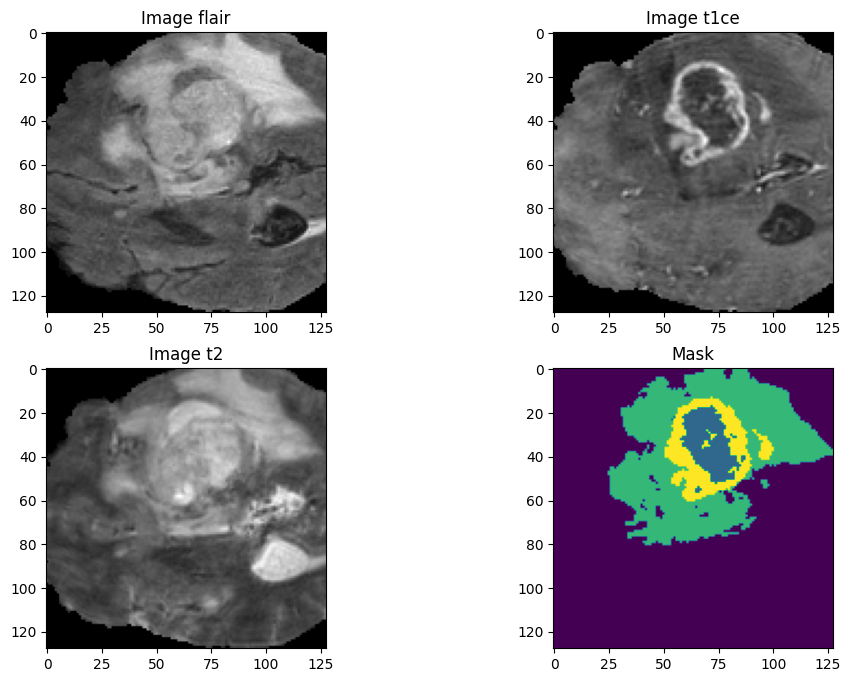

In [8]:
n_slice=random.randint(0, test_mask.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

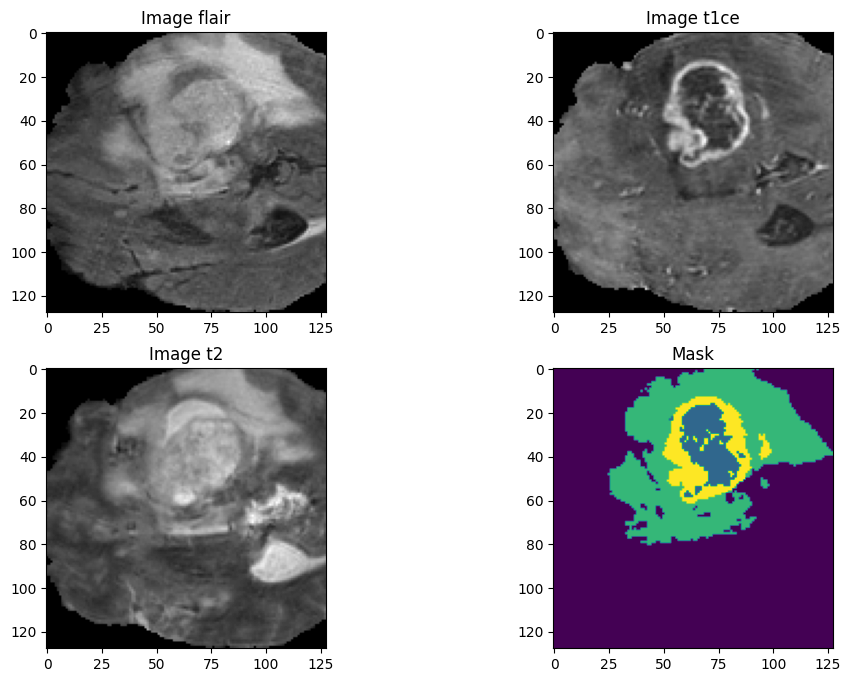

In [9]:

img_num = random.randint(0,img.shape[0]-1)
# img_num = 1
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
# n_slice = 64
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Defining The 3D Unet model

In [10]:
kernel_initializer = 'he_uniform'
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [11]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [13]:
# train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
# train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

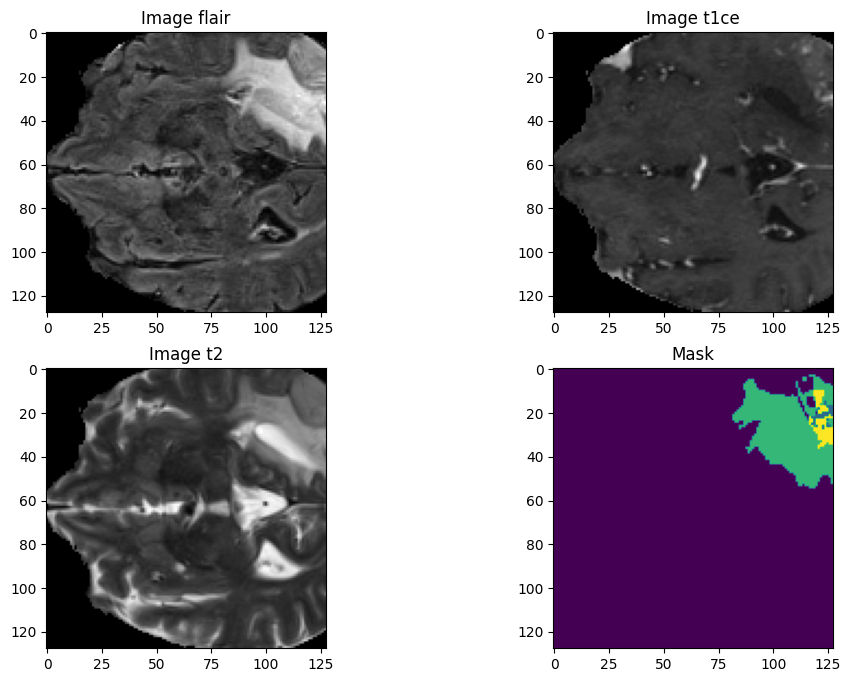

In [14]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [16]:

# train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
# train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "/kaggle/input/brats2020/input_data_128/val/images/"
val_mask_dir = "/kaggle/input/brats2020/input_data_128/val/masks/"

train_img_list=sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

In [17]:
# train_img_list

In [18]:
# train_mask_list

In [19]:
batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

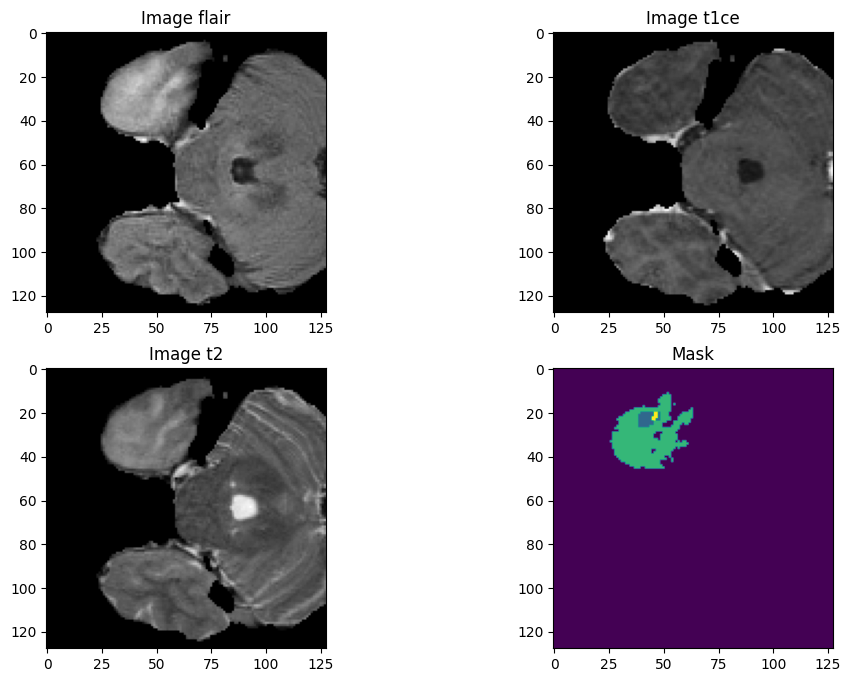

In [20]:
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [21]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

Downloading the loss function from the python library segmentation_models_3d

In [22]:
!pip install segmentation_models_3d


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 6.4 MB/s eta 0:00:00


Defining a total loss function which is a combination of both categorical focal loss and dice loss, and using the proper metrics

In [23]:
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# mean_iou = tf.keras.metrics.MeanIoU(num_classes=4)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), tf.keras.metrics.MeanIoU(num_classes=4)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)
print(1)

Segmentation Models: using `tf.keras` framework.
1


In [24]:
import tensorflow as tf
from keras.losses import Loss
from keras.utils import get_custom_objects

# Register the custom loss function
# get_custom_objects().update({"dice_loss_plus_1focal_loss": total_loss})


# get_custom_objects().update({"iou_score": sm.metrics.IOUScore(threshold=0.5)})

# get_custom_objects().update({"mean_iou_score": tf.keras.metrics.MeanIoU(num_classes=4)})

In [25]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


# # from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

In [26]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [27]:
# from keras.models import load_model
# new_model = load_model('/kaggle/input/3d-unet-120-weights/brats_3d_updated.hdf5')
# results = new_model.evaluate_generator(validation_generator, steps=16)
# print(" validation loss and accuracy are", results)

# history =new_model.fit(train_img_datagen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=120,
#           verbose=1,
#           validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch,
#         )

Training the Model for 150 epochs ,batch size of 4.

In [28]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=150,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/150
64/64 [==============================] - 310s 4s/step - loss: 0.9639 - accuracy: 0.8745 - iou_score: 0.1863 - mean_io_u: 0.3423 - val_loss: 0.9453 - val_accuracy: 0.9504 - val_iou_score: 0.2014 - val_mean_io_u: 0.3524
Epoch 2/150
64/64 [==============================] - 269s 4s/step - loss: 0.9362 - accuracy: 0.9519 - iou_score: 0.2346 - mean_io_u: 0.4427 - val_loss: 0.9352 - val_accuracy: 0.9498 - val_iou_score: 0.2200 - val_mean_io_u: 0.3457
Epoch 3/150
64/64 [==============================] - 272s 4s/step - loss: 0.9285 - accuracy: 0.9492 - iou_score: 0.2335 - mean_io_u: 0.4858 - val_loss: 0.9214 - val_accuracy: 0.9514 - val_iou_score: 0.2388 - val_mean_io_u: 0.4075
Epoch 4/150
64/64 [==============================] - 267s 4s/step - loss: 0.9255 - accuracy: 0.9434 - iou_score: 0.2390 - mean_io_u: 0.4815 - val_loss: 0.9264 - val_accuracy: 0.9190 - val_iou_score: 0.2570 - val_mean_io_u: 0.3487
Epoch 5/150
64/64 [==============================] - 274s 4s/step - loss: 0.9138

Saving the Model Weights

In [29]:
model.save('/kaggle/working/brats_3d.hdf5')

Loss  Metrics

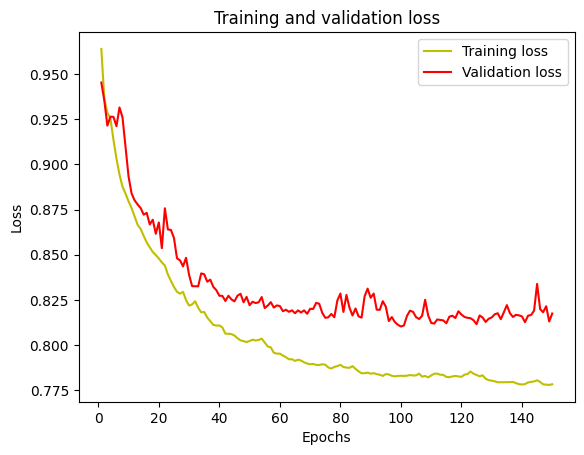

In [30]:

# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), mean_iou]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plotting the Mean Iou metrics

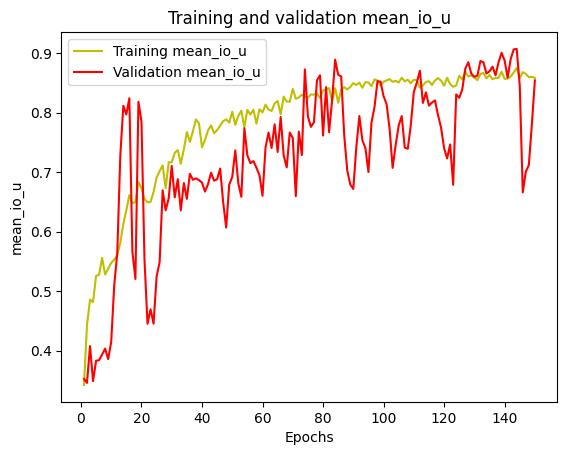

In [41]:
acc = history.history['mean_io_u']
val_acc = history.history['val_mean_io_u']

plt.plot(epochs, acc, 'y', label='Training mean_io_u')
plt.plot(epochs, val_acc, 'r', label='Validation mean_io_u')
plt.title('Training and validation mean_io_u')
plt.xlabel('Epochs')
plt.ylabel('mean_io_u')
plt.legend()
plt.show() 

Plotting the accuracy Metrics

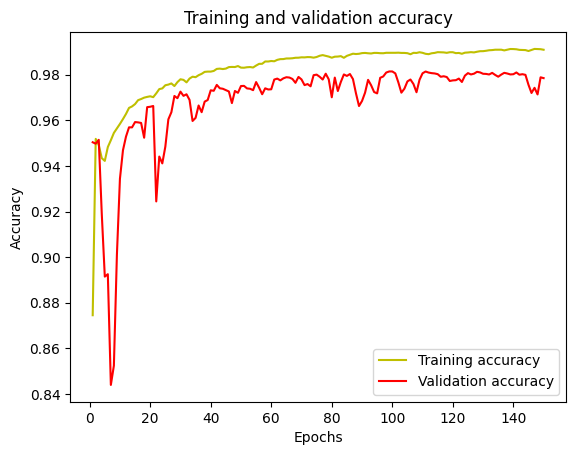

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show() 

Testing

In [33]:


get_custom_objects().update({"dice_loss_plus_1focal_loss": total_loss})


get_custom_objects().update({"iou_score": sm.metrics.IOUScore(threshold=0.5)})

get_custom_objects().update({"mean_iou_score": tf.keras.metrics.MeanIoU(num_classes=4)})

Testing the Model after 150 epochs

In [34]:
from keras.models import load_model
# from keras.utils import custom_object_scope
# import segmentation_models_3D as sm
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)
#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and 
#continue training we need to provide these as custom_objects.
# my_model = load_model('/kaggle/working/brats_3d_new.hdf5')

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
# my_model = load_model('/kaggle/working/brats_3d_new.hdf5', 
#                       custom_objects={'loss': total_loss})


my_model = load_model('/kaggle/working/brats_3d.hdf5')

#Now, let us add the iou_score function we used during our initial training
# my_model = load_model('/kaggle/working/brats_3d_new.hdf5', 
#                       custom_objects={'loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process. 
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )


64/64 [==============================] - 265s 4s/step - loss: 0.7790 - accuracy: 0.9909 - iou_score: 0.8218 - mean_io_u: 0.8615 - val_loss: 0.8262 - val_accuracy: 0.9741 - val_iou_score: 0.6228 - val_mean_io_u: 0.8078


In [35]:
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       compile=False)
# from keras.models import load_model
# my_model = load_model('/kaggle/working/brats_3d.hdf5',compile=False)
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
# from keras.metrics import MeanIoU

# batch_size=16 #Check IoU for a batch of images
# test_img_datagen = imageLoader(val_img_dir, val_img_list, 
#                                 val_mask_dir, val_mask_list, batch_size)

# #Verify generator.... In python 3 next() is renamed as __next__()
# test_image_batch, test_mask_batch = test_img_datagen.__next__()

# test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
# test_pred_batch = my_model.predict(test_image_batch)
# test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

# n_classes = 4
# IOU_keras = MeanIoU(num_classes=n_classes)  
# IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
# print("Mean IoU =", IOU_keras.result().numpy())

In [36]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 [==============================] - 9s 9s/step
Mean IoU = 0.760749


In [37]:
# my_model = load_model('/kaggle/working/brats_3d_new.hdf5')
img_num = 82

test_img = np.load("/kaggle/input/brats2020/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/kaggle/input/brats2020/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_mask_argmax))
print(np.unique(test_prediction_argmax))

1/1 [==============================] - 1s 1s/step
(128, 128, 128)
(128, 128, 128)
[0 1 2 3]
[0 1 2 3]


In [38]:
img_num = 111

test_img = np.load("/kaggle/input/brats2020/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/kaggle/input/brats2020/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 0s 47ms/step


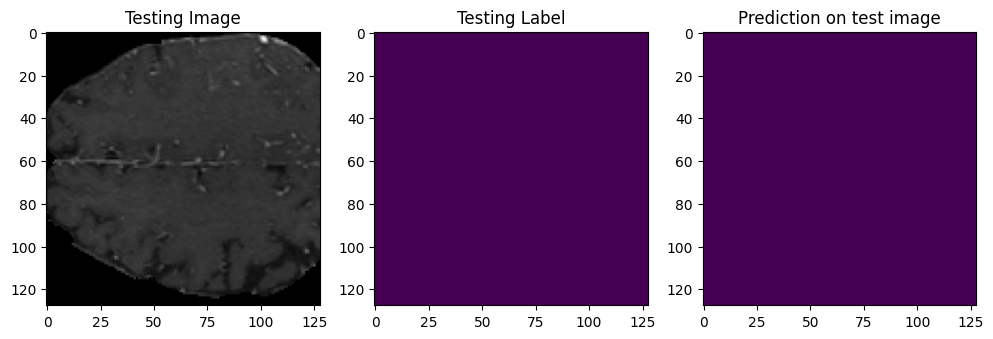

In [39]:
from matplotlib import pyplot as plt
import random

n_slice=random.randint(0, test_prediction_argmax.shape[2])
# n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

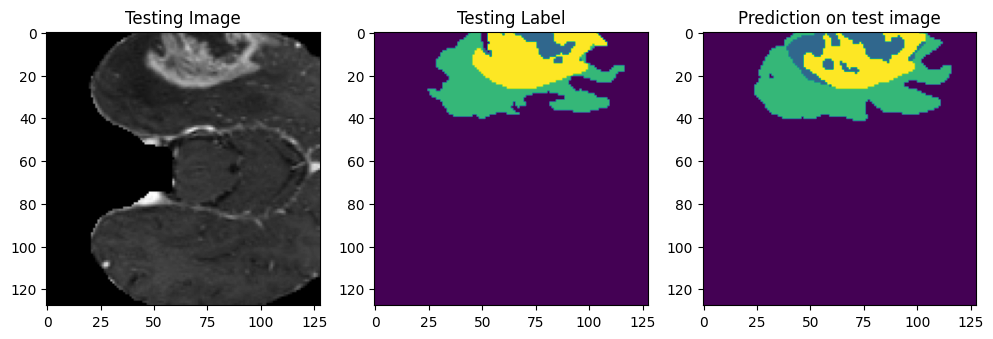

In [40]:
from matplotlib import pyplot as plt
import random

n_slice=random.randint(0, test_prediction_argmax.shape[2])
# n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()